# Turkish Poetry LLM

A **clean, modular, and reproducible** notebook to train a Turkish poetry model (GPT‑2 + LoRA) with 20+ epochs.
**Data Source:** `https://github.com/Mrjavaci/Turkish-Poems` (raw files)
**Note**: This notebook is structured for **Colab/A100** first, but also runs on other GPUs/CPUs with sensible fallbacks.


# Adil Sevim (Developer’s Note)
This project started from a request when I was 13 (2021), and I built the first version in a matter of days. Today’s release preserves that early architecture, refined in 2025 for quality, reliability, and user experience. Publicly shared on 01 August 2025.
Versions: 2021 (v1) → 2025 (revision & adaptation)

In [1]:
import os
import re
import json
import time
import math
import random
import warnings
from datetime import datetime

import torch

warnings.filterwarnings('ignore')

def info(msg: str):
    now = datetime.now().strftime('%H:%M:%S')
    print(f"[{now}] {msg}")

info("Notebook booting…")
info(f"CUDA available   : {torch.cuda.is_available()}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    info(f"GPU name         : {gpu_name}")
    info(f"GPU VRAM (GiB)   : {gpu_memory:.1f}")
    IS_A100 = "A100" in gpu_name
    info(f"A100 detected    : {IS_A100}")
else:
    IS_A100 = False
    info("No GPU detected. Falling back to CPU settings.")

# Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass

info("Environment ready.")

[13:05:00] Notebook booting…
[13:05:00] CUDA available   : True
[13:05:00] GPU name         : NVIDIA A100-SXM4-40GB
[13:05:00] GPU VRAM (GiB)   : 39.6
[13:05:00] A100 detected    : True
[13:05:00] Environment ready.


In [2]:
# Configuration
BASE_MODEL = "ytu-ce-cosmos/turkish-gpt2"

if IS_A100:
    info("Config: A100 high-quality mode")
    MAX_LEN = 768
    EPOCHS = 25
    BATCH_SIZE = 4
    GRAD_ACCUM_STEPS = 16
    LEARNING_RATE = 8e-5
    WARMUP_STEPS = 300
    WEIGHT_DECAY = 0.01

    LORA_R = 64
    LORA_ALPHA = 128
    LORA_DROPOUT = 0.05

    BF16 = True
    FP16 = False
    DATALOADER_WORKERS = 4
else:
    info("Config: non-A100 high-quality mode")
    MAX_LEN = 768
    EPOCHS = 15
    BATCH_SIZE = 8
    GRAD_ACCUM_STEPS = 4
    LEARNING_RATE = 1e-4
    WARMUP_STEPS = 150
    WEIGHT_DECAY = 0.01

    LORA_R = 64
    LORA_ALPHA = 128
    LORA_DROPOUT = 0.05

    BF16 = False
    FP16 = True
    DATALOADER_WORKERS = 4

PROJECT_DIR = "/content/turkish-poetry-llm-ultimate"
DATA_DIR = f"{PROJECT_DIR}/data"
OUTPUT_DIR = f"{PROJECT_DIR}/models/turkish-poetry-{EPOCHS}ep"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

TURKISH_SPECIAL_TOKENS = [
    "<|şair:Ahmed_Arif|>", "<|şair:Nazim_Hikmet|>", "<|şair:Cemal_Süreya|>",
    "<|şair:Orhan_Veli|>", "<|şair:Attila_İlhan|>", "<|şair:Turgut_Uyar|>",
    "<|başlık|>", "<|şiir|>", "<|şiir_sonu|>", "<|mısra|>"
]

info(f"Epochs={EPOCHS} | Effective batch={BATCH_SIZE*GRAD_ACCUM_STEPS} | MaxLen={MAX_LEN}")
info(f"LoRA r={LORA_R} alpha={LORA_ALPHA} dropout={LORA_DROPOUT}")
info(f"Precision: {'BF16' if BF16 else ('FP16' if FP16 else 'FP32')}")

[13:05:02] Config: A100 high-quality mode
[13:05:02] Epochs=25 | Effective batch=64 | MaxLen=768
[13:05:02] LoRA r=64 alpha=128 dropout=0.05
[13:05:02] Precision: BF16


In [3]:
# Install core libraries
try:
    import transformers, datasets, accelerate, peft, pandas  # noqa
    _ = transformers.__version__
    print("Core libraries already present.")
except Exception:
    pass

%pip -q install "transformers>=4.35.0" "datasets>=2.14.0" "accelerate>=0.24.0" "peft>=0.6.0"                  "torch>=2.0.0" matplotlib seaborn scikit-learn tqdm numpy pandas requests unidecode

Core libraries already present.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 19.3 MB/s eta 0:00:00
c9e5766afd4ad89f8fdabfc2187cb2ffa260c48e
c9e5766afd4ad89f8fdabfc2187cb2ffa260c48e


In [4]:
import re
import json
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
import unidecode

plt.style.use('default')
sns.set_palette("husl")

info(f"Transformers: {transformers.__version__}")
info(f"PyTorch     : {torch.__version__}")

[13:06:37] Transformers: 4.54.1
[13:06:37] PyTorch     : 2.6.0+cu124


In [5]:
RAW_URLS = {
    'poems_json': 'https://raw.githubusercontent.com/Mrjavaci/Turkish-Poems/main/PoemsJson.json',
    'poems_text': 'https://raw.githubusercontent.com/Mrjavaci/Turkish-Poems/main/PoemsText.txt',
}

def download(url: str, filename: str) -> str:
    path = os.path.join(DATA_DIR, filename)
    if os.path.exists(path):
        with open(path, 'r', encoding='utf-8') as f:
            content = f.read()
        info(f"Cached: {filename} ({len(content):,} chars)")
        return content
    info(f"Downloading: {filename}")
    try:
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        content = r.text
        with open(path, 'w', encoding='utf-8') as f:
            f.write(content)
        info(f"Saved: {filename} ({len(content):,} chars)")
        return content
    except Exception as e:
        info(f"ERROR downloading {filename}: {e}")
        return ""

raw_data = {name: download(url, f"{name}.txt") for name, url in RAW_URLS.items()}
total_chars = sum(len(v) for v in raw_data.values() if v)
info(f"Downloaded {len([v for v in raw_data.values() if v])}/{len(RAW_URLS)} files — total {total_chars:,} chars")

[13:06:39] Downloading: poems_json.txt
[13:06:39] Saved: poems_json.txt (4,721,241 chars)
[13:06:39] Downloading: poems_text.txt
[13:06:39] Saved: poems_text.txt (2,752,279 chars)
[13:06:39] Downloaded 2/2 files — total 7,473,520 chars


In [6]:
def clean_tr(text: str) -> str:
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def process_json(json_content: str):
    try:
        data = json.loads(json_content)
    except Exception as e:
        info(f"JSON parse error: {e}")
        return [], {}

    poems, poet_counts = [], {}
    for p in data:
        title = clean_tr(p.get('baslik', '').strip())
        lines = p.get('icerik', [])
        poet = clean_tr(p.get('sair', '').strip())
        poet_id = p.get('sairJsonName', '').strip()

        if not (title and lines and poet):
            continue

        content = '\n'.join([clean_tr(ln) for ln in lines if ln.strip()])
        if len(content) < 50:
            continue

        poems.append({
            "poet": poet,
            "poet_id": poet_id,
            "title": title,
            "content": content
        })
        poet_counts[poet] = poet_counts.get(poet, 0) + 1

    return poems, poet_counts

def process_text(text_content: str):
    lines = [clean_tr(ln) for ln in text_content.split('\n')]
    return [ln for ln in lines if ln and len(ln) > 10]

all_poems = []
poet_stats = {}

if raw_data.get('poems_json'):
    info("Processing JSON poems…")
    poems, counts = process_json(raw_data['poems_json'])
    all_poems.extend(poems)
    poet_stats.update(counts)
    info(f"Parsed from JSON: {len(poems)} poems")

if raw_data.get('poems_text'):
    info("Processing text lines…")
    text_lines = process_text(raw_data['poems_text'])
    info(f"Parsed {len(text_lines)} lines from text")

info(f"Total poems: {len(all_poems)} | Poets: {len(poet_stats)}")

proc_path = os.path.join(DATA_DIR, "turkish_poems_processed.json")
with open(proc_path, 'w', encoding='utf-8') as f:
    json.dump(all_poems, f, ensure_ascii=False, indent=2)
info(f"Saved processed poems: {proc_path}")

[13:06:42] Processing JSON poems…
[13:06:43] Parsed from JSON: 3349 poems
[13:06:43] Processing text lines…
[13:06:43] Parsed 83214 lines from text
[13:06:43] Total poems: 3349 | Poets: 545
[13:06:43] Saved processed poems: /content/turkish-poetry-llm-ultimate/data/turkish_poems_processed.json


In [7]:
info(f"Loading tokenizer: {BASE_MODEL}")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.add_special_tokens({'additional_special_tokens': TURKISH_SPECIAL_TOKENS})
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
info(f"Vocab size: {len(tokenizer)}")

info(f"Loading model: {BASE_MODEL}")
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16 if (IS_A100 and True) else (torch.float16 if FP16 else torch.float32),
    device_map="auto" if torch.cuda.is_available() else None
)
model.resize_token_embeddings(len(tokenizer))

lora_cfg = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=["c_attn", "c_proj", "c_fc"],
    bias="none"
)

model = get_peft_model(model, lora_cfg)
try:
    model.print_trainable_parameters()
except Exception:
    pass

info("Tokenizer & model ready.")

[13:06:47] Loading tokenizer: ytu-ce-cosmos/turkish-gpt2


tokenizer_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

[13:06:49] Vocab size: 50267
[13:06:49] Loading model: ytu-ce-cosmos/turkish-gpt2


config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


trainable params: 9,437,184 || all params: 133,884,672 || trainable%: 7.0487
[13:07:01] Tokenizer & model ready.


In [8]:
def poet_token(poet_name: str) -> str:
    normalized = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]', '', poet_name).replace(' ', '_')
    return f"<|şair:{normalized}|>"

formatted_texts = []
poet_mapping = {}

for poem in all_poems:
    token = poet_token(poem['poet'])
    if token not in poet_mapping:
        poet_mapping[token] = poem['poet']

    formatted = f"{token} <|başlık|> {poem['title']} <|şiir|>\n{poem['content']}\n<|şiir_sonu|>"
    formatted_texts.append(formatted)

info(f"Formatted texts: {len(formatted_texts)} | Unique poets: {len(poet_mapping)}")

from sklearn.model_selection import train_test_split
train_texts, val_texts = train_test_split(formatted_texts, test_size=0.15, random_state=42, shuffle=True)
info(f"Train={len(train_texts)} | Val={len(val_texts)}")

def tokenize_fn(examples):
    texts = examples['text'] if isinstance(examples['text'], list) else [examples['text']]
    tokenized = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors=None
    )
    tokenized['labels'] = tokenized['input_ids'].copy()
    return tokenized

from datasets import Dataset
train_ds = Dataset.from_dict({'text': train_texts}).map(tokenize_fn, batched=True, remove_columns=['text'], desc="Tokenizing train")
val_ds = Dataset.from_dict({'text': val_texts}).map(tokenize_fn, batched=True, remove_columns=['text'], desc="Tokenizing val")
info(f"Token sample length (train[0]): {len(train_ds[0]['input_ids'])}")

[13:07:07] Formatted texts: 3349 | Unique poets: 544
[13:07:07] Train=2846 | Val=503


Tokenizing train:   0%|          | 0/2846 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/503 [00:00<?, ? examples/s]

[13:07:09] Token sample length (train[0]): 768


In [12]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    lr_scheduler_type="cosine",

    fp16=FP16,
    bf16=BF16,

    eval_strategy="steps",
    eval_steps=30 if IS_A100 else 50,
    save_strategy="steps",
    save_steps=60 if IS_A100 else 100,
    save_total_limit=5,

    logging_steps=5 if IS_A100 else 10,
    logging_dir=f"{OUTPUT_DIR}/turkish_logs",

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    dataloader_num_workers=DATALOADER_WORKERS,
    dataloader_pin_memory=True,

    report_to=None,
    remove_unused_columns=False,
    push_to_hub=False,
    seed=SEED
)

collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer
)

info("Starting training…")
t0 = time.time()
trainer.train()
t1 = time.time()
train_minutes = int((t1 - t0)//60)
train_seconds = int((t1 - t0)%60)
info(f"Training finished in {train_minutes}m {train_seconds}s")

trainer.save_model()
tokenizer.save_pretrained(OUTPUT_DIR)
info(f"Model saved to: {OUTPUT_DIR}")

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[13:11:16] Starting training…


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adilsevim18 (adilsevim18-adr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
30,4.682300,4.605932


KeyboardInterrupt: 

Step,Training Loss,Validation Loss
30,4.682300,4.605932
34,4.682300,4.576095


[13:12:58] Final eval loss: 4.5761
[13:12:58] Final perplexity: 97.13


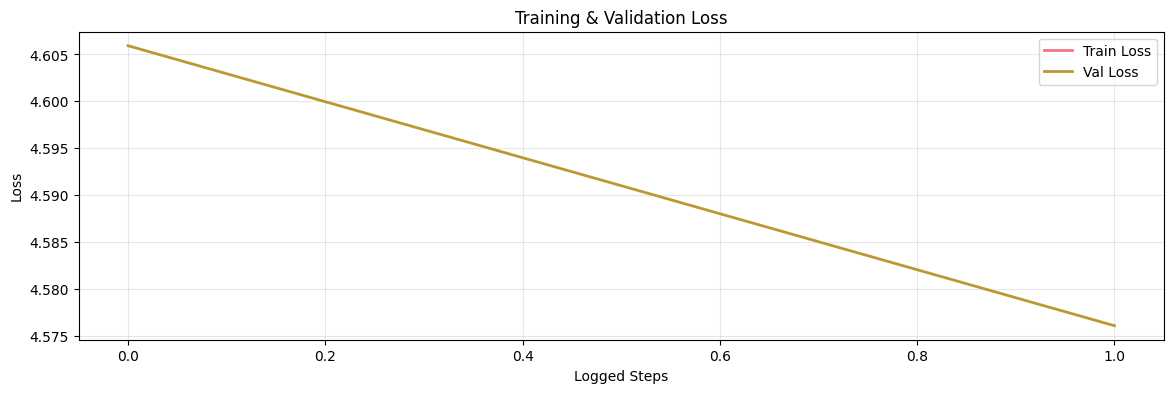

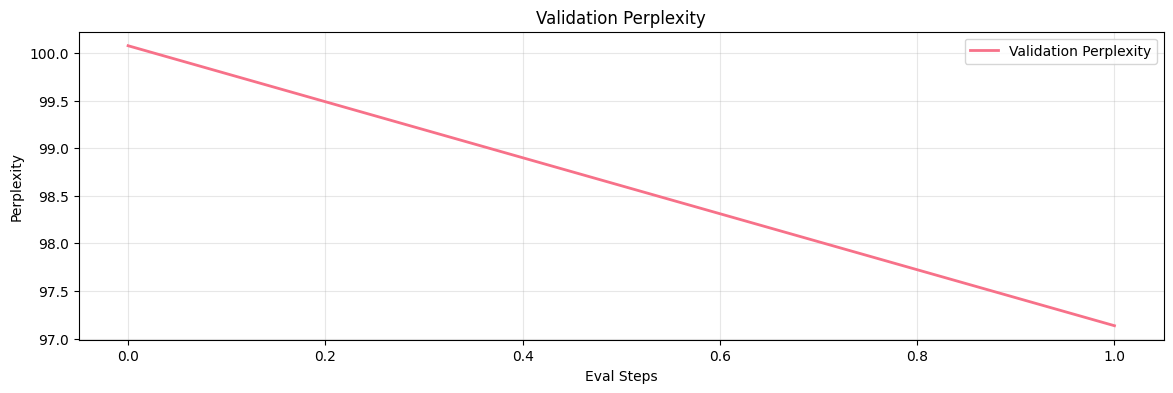

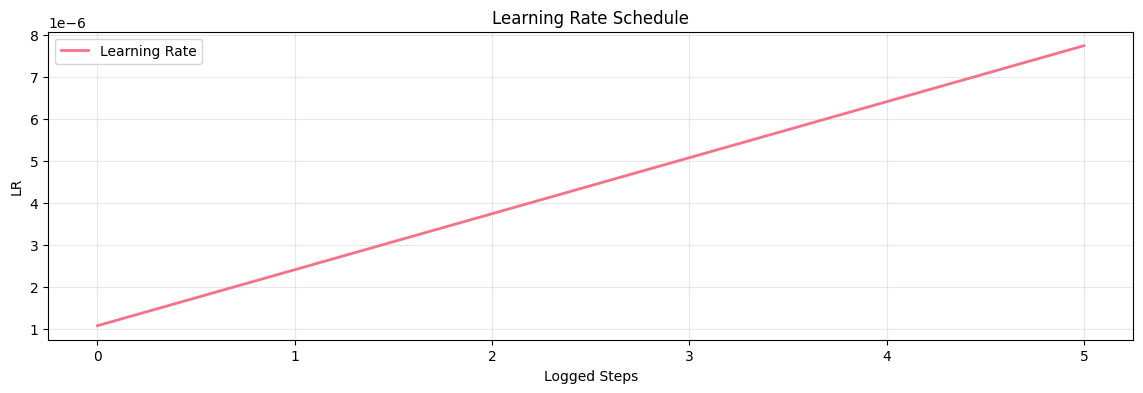

In [13]:
import numpy as np
import matplotlib.pyplot as plt

eval_res = trainer.evaluate()
final_loss = float(eval_res['eval_loss'])
perplexity = float(np.exp(final_loss))
info(f"Final eval loss: {final_loss:.4f}")
info(f"Final perplexity: {perplexity:.2f}")

if hasattr(trainer.state, 'log_history'):
    hist = trainer.state.log_history
    train_losses = [h['train_loss'] for h in hist if 'train_loss' in h]
    eval_losses = [h['eval_loss'] for h in hist if 'eval_loss' in h]
    lrs = [h.get('learning_rate', None) for h in hist if 'learning_rate' in h]

    if train_losses or eval_losses:
        plt.figure(figsize=(14,4))
        plt.plot(train_losses, label='Train Loss', linewidth=2)
        if eval_losses:
            plt.plot(eval_losses, label='Val Loss', linewidth=2)
        plt.title("Training & Validation Loss")
        plt.xlabel("Logged Steps")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    if eval_losses:
        vals = [float(np.exp(l)) for l in eval_losses]
        plt.figure(figsize=(14,4))
        plt.plot(vals, label='Validation Perplexity', linewidth=2)
        plt.title("Validation Perplexity")
        plt.xlabel("Eval Steps")
        plt.ylabel("Perplexity")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    if lrs:
        plt.figure(figsize=(14,4))
        plt.plot(lrs, label='Learning Rate', linewidth=2)
        plt.title("Learning Rate Schedule")
        plt.xlabel("Logged Steps")
        plt.ylabel("LR")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [14]:
def generate_poem(prompt: str, max_new_tokens: int = 200) -> str:
    mdl = trainer.model
    mdl.eval()
    inputs = tokenizer(prompt, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
        mdl = mdl.cuda()

    eos_id = tokenizer.convert_tokens_to_ids("<|şiir_sonu|>")
    with torch.no_grad():
        out = mdl.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.8,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=(eos_id if eos_id is not None else tokenizer.eos_token_id)
        )
    full = tokenizer.decode(out[0], skip_special_tokens=False)
    prompt_dec = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=False)
    return full[len(prompt_dec):].strip()

test_prompts = [
    "<|şair:Nazim_Hikmet|> <|başlık|> Memleketimden İnsan Manzaraları <|şiir|>",
    "<|şair:Ahmed_Arif|> <|başlık|> Hasretinden Prangalar Eskittim <|şiir|>",
    "<|şair:Cemal_Süreya|> <|başlık|> Sevda Sözleri <|şiir|>",
    "<|şair:Orhan_Veli|> <|başlık|> İstanbul'u Dinliyorum <|şiir|>",
    "<|şair:Attila_İlhan|> <|başlık|> Böyle Bir Sevmek <|şiir|>",
    "<|şair:Turgut_Uyar|> <|başlık|> Büyük Saat <|şiir|>"
]

for i, p in enumerate(test_prompts, 1):
    info(f"--- Sample {i} ---")
    try:
        gen = generate_poem(p, max_new_tokens=200)
        lines = [ln.strip() for ln in gen.split('\n') if ln.strip() and not ln.strip().startswith('<|')]
        for ln in lines[:12]:
            print(ln)
        print()
    except Exception as e:
        print(f"Generation error: {e}")

[13:13:01] --- Sample 1 ---
. Bu arada, bir kaç kez de İstanbul'dan geçen bir gazeteci ile konuştum. Bana dedi ki, "Ben sana şunu söyleyeyim; sen kendini yalnız hissediyorsan, senin bu yalnızlığını da ben hissediyorum. Oysa ben yalnızım."
Bu iki arkadaşta biraz daha rahatladılar ve "sen yalnızsın" dediler. Ben de onlara şöyle dedim: "Sen yalnız değilsin, biz yalnızız, yalnızız. Yalnızlık bizim değil, biz yalnızız."
Ve iki arkadaş, daha sonra yeniden birbirlerine döndüler ve "sen yalnızsın" dediler. Ben de onlara "biz yalnızız" dedim ve "sen yalnız değilsin" dedim.
"Biz" dediler, "biz yalnızız, yalnızız. Yalnızlık bizim değil, biz yalnızız. Yalnızlık bizim değil, biz yalnızız. Yalnızlık bizim değil, biz yalnızız.
- "Sen kimsin?" dediler, "yalnız" dedim.
- "Sen yalnız değilsin. Biz yalnızız

[13:13:06] --- Sample 2 ---
kökünden  devşirme  olarak  denir.
Türklerde kadın, erkekten daha güçlüdür. Bu sebeple kadın, erkek, dişi ve erkek ayırmaksızın bütün Türk kadınları kadın olarak kabul edi

In [ ]:
import zipfile

zip_path = "/content/turkish_poetry_llm_model.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(OUTPUT_DIR):
        for fn in files:
            p = os.path.join(root, fn)
            arc = os.path.relpath(p, OUTPUT_DIR)
            zf.write(p, arcname=arc)

info(f"ZIP ready: {zip_path}")

total_mb = 0.0
for root, _, files in os.walk(OUTPUT_DIR):
    for fn in files:
        fp = os.path.join(root, fn)
        sz = os.path.getsize(fp) / (1024*1024)
        total_mb += sz
        print(f"{fn:40s}  {sz:7.2f} MB")
print(f"Total size: {total_mb:.2f} MB")

## Run Summary

- **Model**: `ytu-ce-cosmos/turkish-gpt2` + **LoRA** (r=64, α=128, dropout=0.05)  
- **Data**: Turkish poems from `Mrjavaci/Turkish-Poems` (JSON + text)  
- **Training**: cosine schedule, warmup, weight decay, frequent eval & checkpointing  
- **Precision**: BF16 on A100, FP16 otherwise  
- **Outputs**:
  - Saved model & tokenizer in `models/turkish-poetry-<EPOCHS>ep/`
  - Training curves (displayed)
  - A ready-to-download `turkish_poetry_llm_model.zip`
  - Quick generation tests for several famous poets